<summary>Table of Contents</summary>

- [1. Comparison of models](#1-comparison-of-models)
- [2. Sequence length](#2-sequence-length)
- [3. Self-supervised](#3-self-supervised)
- [4. Ablation study](#4-ablation-study)
- [5. TimeLLM](#5-timellm)
- [6. Decomposition](#6-decomposition)

This script summarizes results from all experiments and represents them in plots. On the plots is UK, but in tables is GB. GB here is United Kingdom.

In [7]:
import pandas as pd
import os
from utils.helper import style_dataframe, \
                         map_country_name, \
                         read_results_csv, \
                         group_and_reindex_df, \
                         choose_best_patchtst_model, \
                         calculate_improvement

from utils.plot_final_results import plot_results_models_multiple_countries, \
                                      plot_comparison_for_metrics, \
                                      plot_barplots


# 1. Comparison of models

In [8]:
# Read data
naive_df = read_results_csv('naive/metrics_persistence_countries_minmax.csv',
                            columns_to_extract = ('Persistence', ['RMSE', 'MAE'])
                            )
arima_df = read_results_csv('arima/metrics_arima_countries_minmax.csv',
                             columns_to_extract = ('(S)ARIMA', ['RMSE', 'MAE'])
                             )
informer_df = read_results_csv('informer/informer.csv',
                               columns_to_extract = ('Informer', ['RMSE', 'MAE'])
                               )
patchtst_df = read_results_csv('patchtst/patchtst_128.csv',
                               columns_to_extract = ('PatchTST/42', ['RMSE', 'MAE'])
                               )
patchtst_21_df = read_results_csv('patchtst/patchtst_168_21_patch.csv',
                                   columns_to_extract = ('PatchTST/21', ['RMSE', 'MAE'])
                                   )
patchtst_64_df = read_results_csv('patchtst/patchtst_bs128_pl512.csv',
                                   columns_to_extract = ('PatchTST/64', ['RMSE', 'MAE'])
                                   )

# Concat all dfs
all_df = pd.concat([patchtst_df, informer_df, arima_df, naive_df], axis=1)

# Scale
scale = 10**2

# Change country codes to country names
level_names = all_df.index.names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index], 
    names=level_names
)
all_df_scale_store = all_df * scale

# Highlight the minimum values in bold
styled_df = style_dataframe(all_df_scale_store, decimal_places=2)
styled_df

In [9]:
# Save styled dataframe to HTML
path = './stored_elements/tables'

if not os.path.exists(path):
    os.makedirs(path)
styled_df.to_html(os.path.join(path, 'model_comparison_10_power_2.html'), index=True)

Create plots.

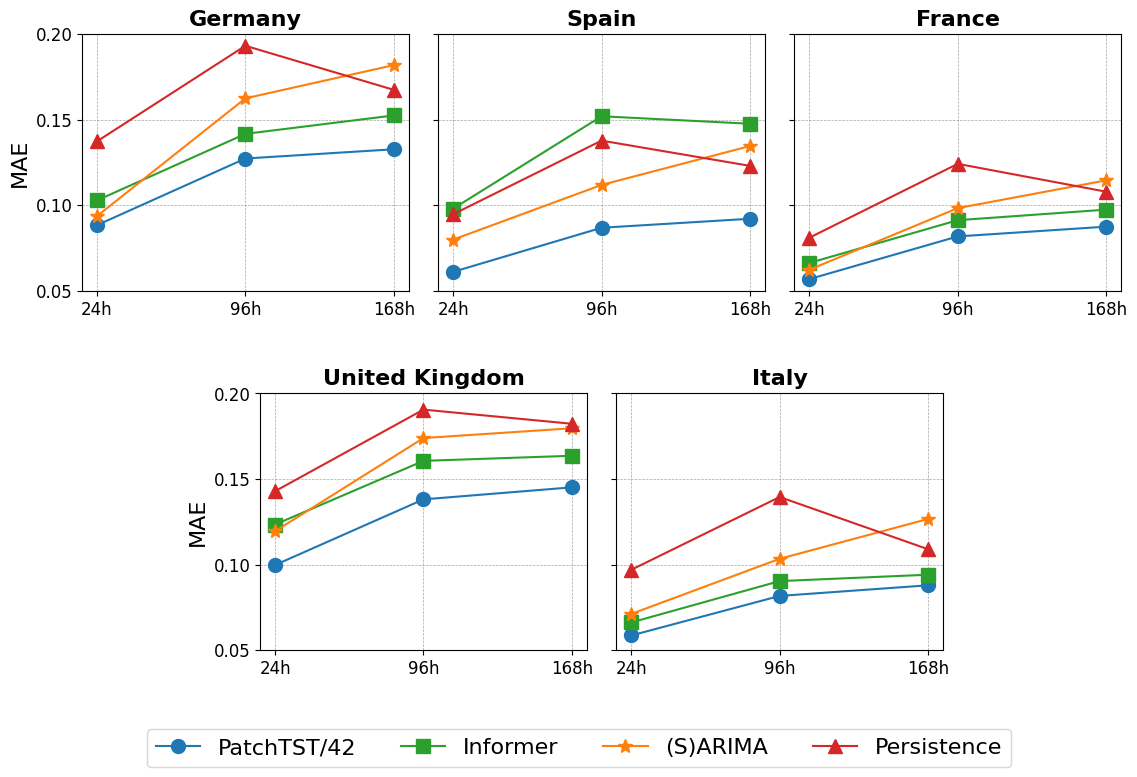

In [22]:
plot_results_models_multiple_countries(all_df, 
                                       function="lines", 
                                       eval_metric='MAE',
                                       decimal_places=2
                                       )

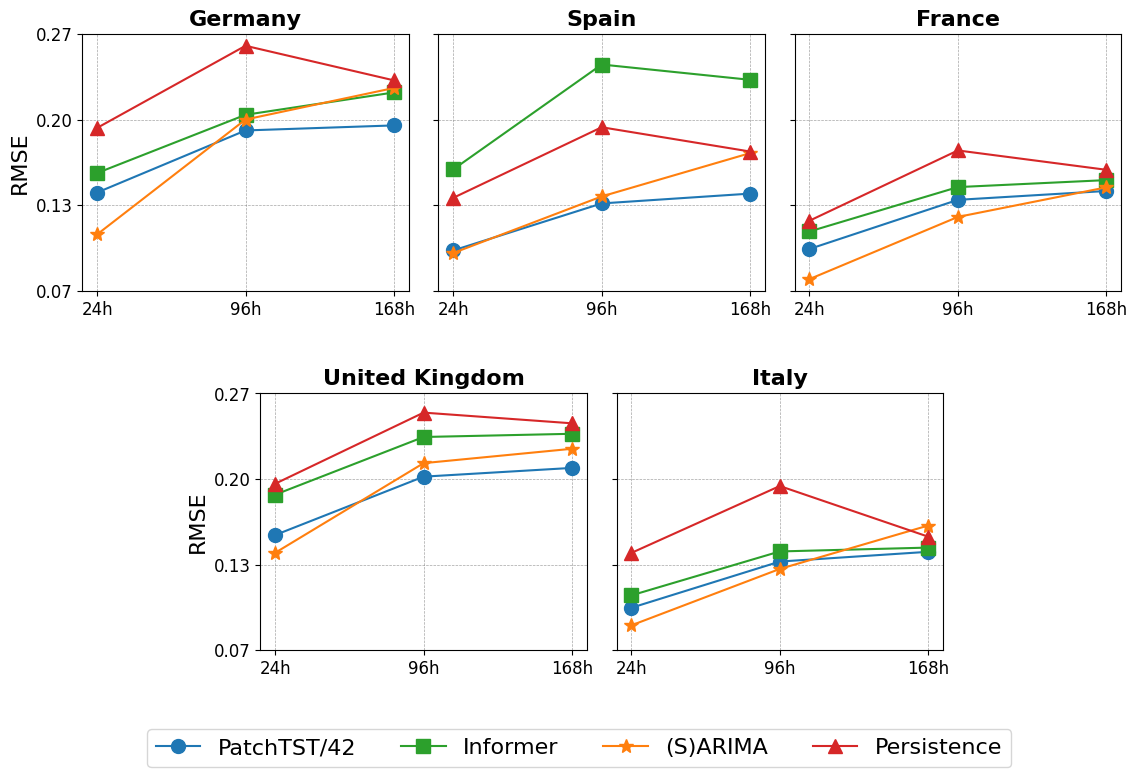

In [23]:
plot_results_models_multiple_countries(all_df, 
                                       function="lines", 
                                       eval_metric='RMSE',
                                       decimal_places=2)

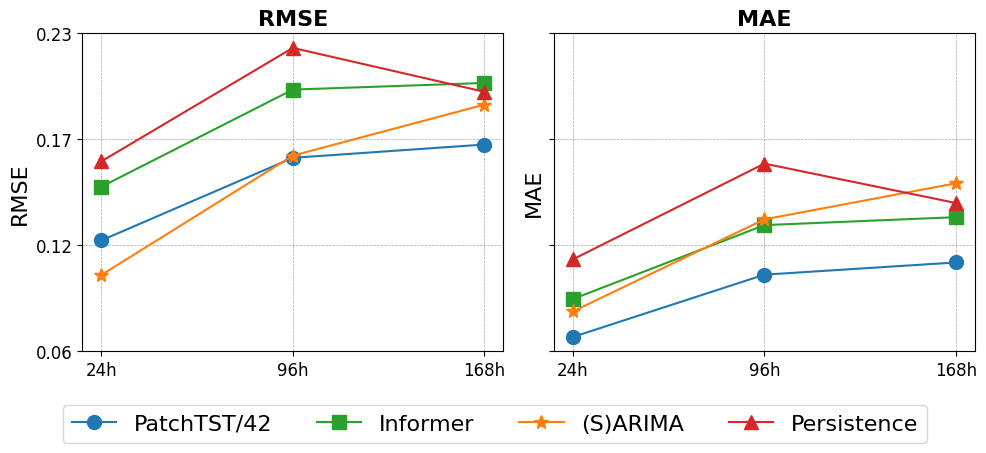

In [24]:
# Averaged by pred_len
to_group = 'Pred_len'
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_comparison_for_metrics(grouped_means, plot_x_axis=to_group, plot_type="lines")

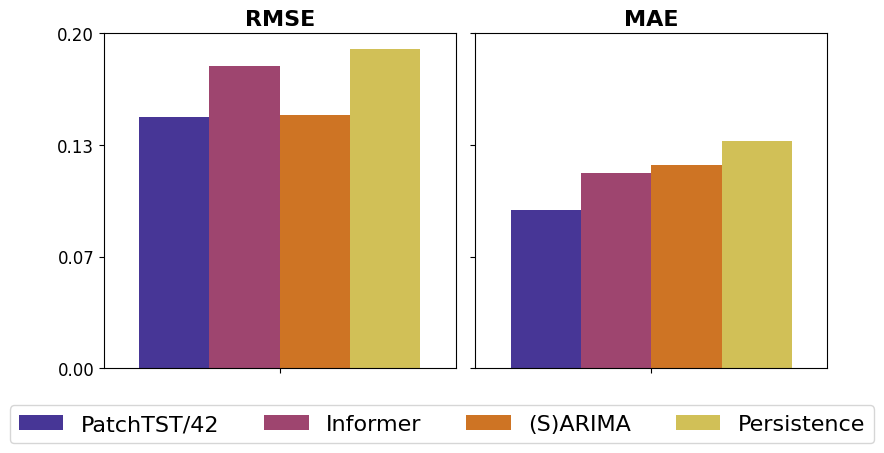

In [25]:
to_group = ['Country', 'Pred_len']
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_barplots(grouped_means, 'Model', col_name='Metrics', palette='CMRmap')

In [26]:
calculate_improvement(grouped_means, 
                      base_mae_model='PatchTST/42', 
                      model_to_compare_mae='Informer', 
                      model_to_compare_rmse='(S)ARIMA')

Improvement of PatchTST/42 over Informerin terms of MAE: 19.12 %
Improvement of PatchTST/42 over (S)ARIMAin terms of RMSE: 0.84 %


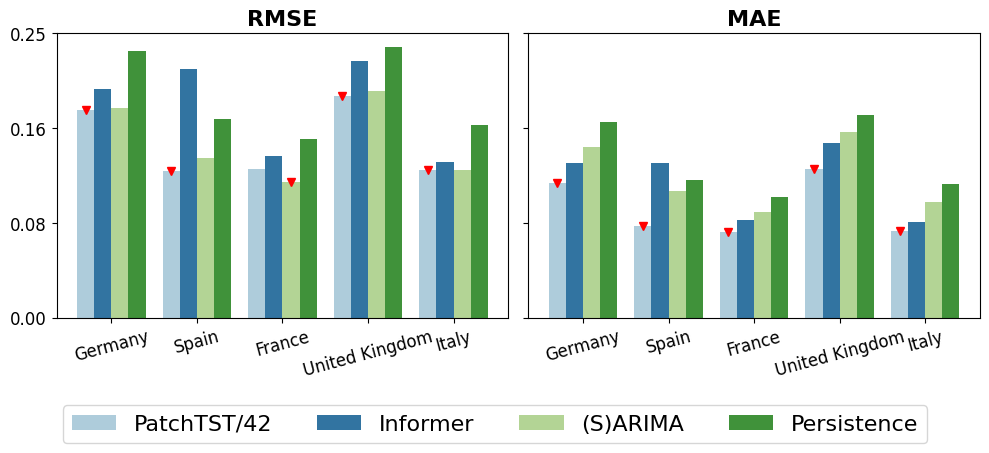

In [27]:
# Averaged by country
to_group = 'Country'
grouped_means = group_and_reindex_df(all_df)
plot_comparison_for_metrics(grouped_means, plot_x_axis=to_group, plot_min_markers=True, plot_max_markers=False, palette="Paired")

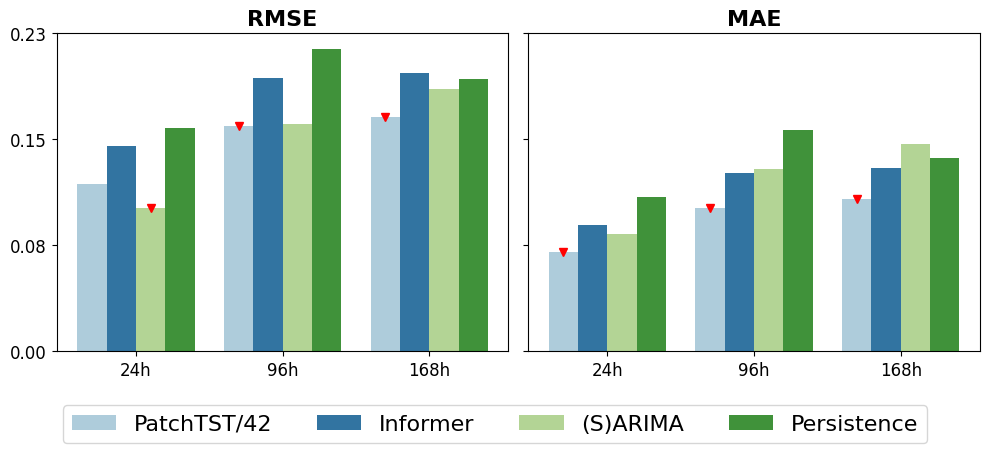

In [28]:
# Averaged by pred_len
to_group = 'Pred_len'
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_comparison_for_metrics(grouped_means, plot_x_axis=to_group, plot_min_markers=True, palette="Paired")

# 2. Sequence length

In [10]:
all_df = pd.concat([patchtst_64_df, patchtst_df, patchtst_21_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)
# Scale
all_df_scale = all_df * scale

# Highlight the minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [11]:
# With best PatchTST configurations
result_df = choose_best_patchtst_model(all_df) * scale

all_df_with_result = pd.concat(
    [result_df, all_df_scale_store.loc[:, all_df_scale_store.columns.get_level_values('Model') != 'PatchTST/42']],
    axis=1
)

all_df_with_result.columns.names = ['Model', 'Metrics']

# Highlight the minimum values in bold.
styled_df = style_dataframe(all_df_with_result, decimal_places=2)
styled_df


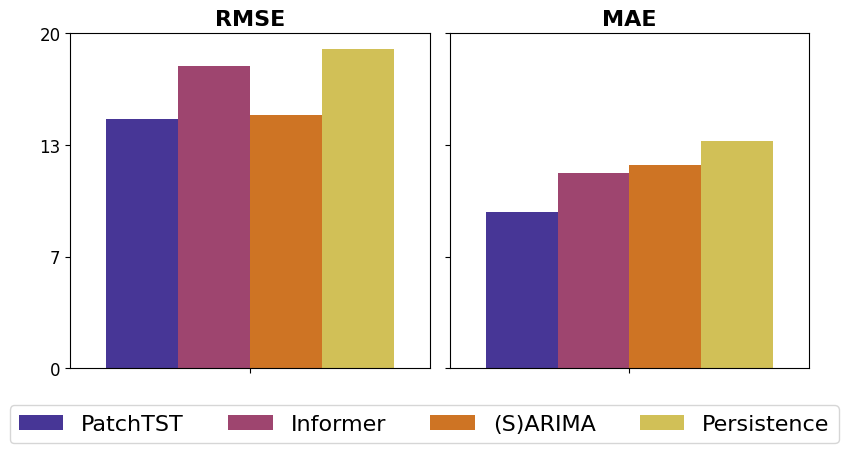

In [31]:
to_group = ['Country', 'Pred_len']
grouped_means = group_and_reindex_df(all_df_with_result, to_group=to_group)
plot_barplots(grouped_means, 'Model', col_name='Metrics', palette='CMRmap', decimal_places=0)

In [ ]:
# Best parameters
calculate_improvement(grouped_means, 
                      base_mae_model='PatchTST', 
                      model_to_compare_mae='Informer', 
                      model_to_compare_rmse='(S)ARIMA')

Improvement of PatchTST over Informerin terms of MAE: 20.02 %
Improvement of PatchTST over (S)ARIMAin terms of RMSE: 1.71 %


In [18]:
styled_df.to_html(os.path.join(path, 'input_512_10_power_2.html'), index=True)

# 3. Self-supervised

In [19]:
# Read data
self_supervised = read_results_csv('patchtst/finetune_results.csv',
                                    columns_to_extract = ('Self-supervised', ['RMSE', 'MAE'])
                                    )

all_df = pd.concat([self_supervised, patchtst_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)
# Scale
all_df_scale = all_df * scale

# Highlight the minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [20]:
styled_df.to_html(os.path.join(path, 'self_supervised_10_power_2.html'), index=True)

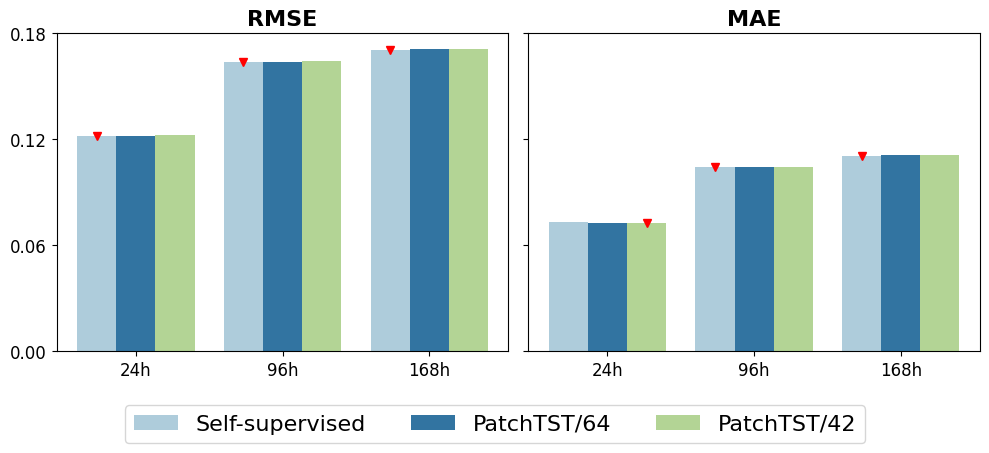

In [ ]:
# all together
# Not visible

all_df = pd.concat([self_supervised, patchtst_64_df, patchtst_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Averaged by country
to_group = 'Pred_len'
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_comparison_for_metrics(grouped_means, plot_x_axis=to_group, plot_min_markers=True, plot_max_markers=False, palette="Paired")

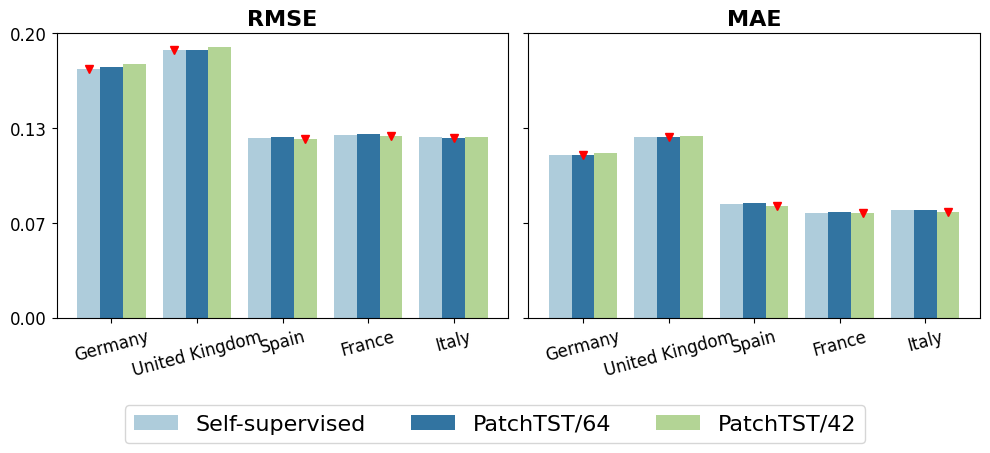

In [22]:
# Averaged by country
to_group = 'Country'
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_comparison_for_metrics(grouped_means, plot_x_axis=to_group, plot_min_markers=True, plot_max_markers=False, palette="Paired")

# 4. Ablation study

In [3]:
# Read data
no_revin = read_results_csv('patchtst/patchtst_no_revin.csv', 
                           columns_to_extract = ('-RevIN', ['RMSE', 'MAE'])
                           )
patchtst_mix_features = read_results_csv('patchtst/patchtst_channel_mixing_MIX_FEATURES.csv',
                                        columns_to_extract = ('CM', ['RMSE', 'MAE'])
                                        )
no_patch = read_results_csv('patchtst/patchtst_no_patching.csv', 
                           columns_to_extract = ('-P', ['RMSE', 'MAE'])
                           )

all_df = pd.concat([patchtst_df, no_revin, patchtst_mix_features, no_patch], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight maximum values in bold
styled_df = style_dataframe(all_df_scale, 'max', decimal_places=2)
styled_df

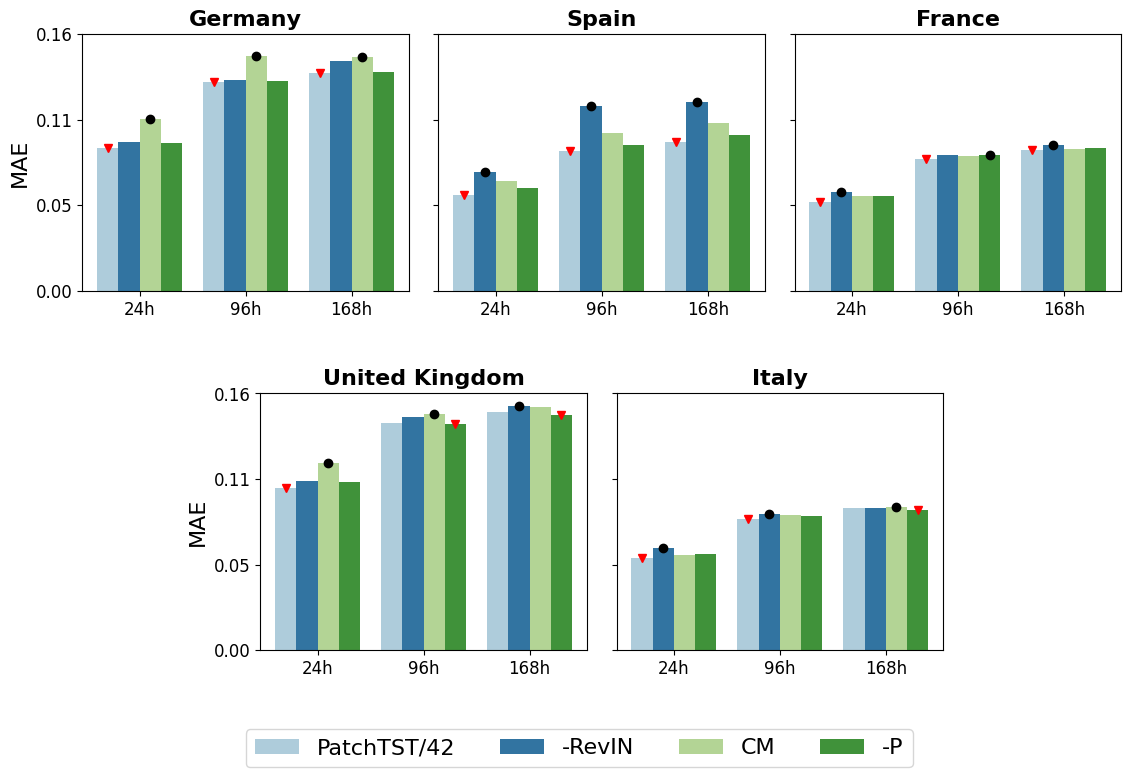

In [4]:
plot_results_models_multiple_countries(all_df, 
                                       function="bars", 
                                       eval_metric='MAE',
                                       palette="Paired",
                                       plot_max_markers=True,
                                       plot_min_markers=True,
                                       decimal_places=2)

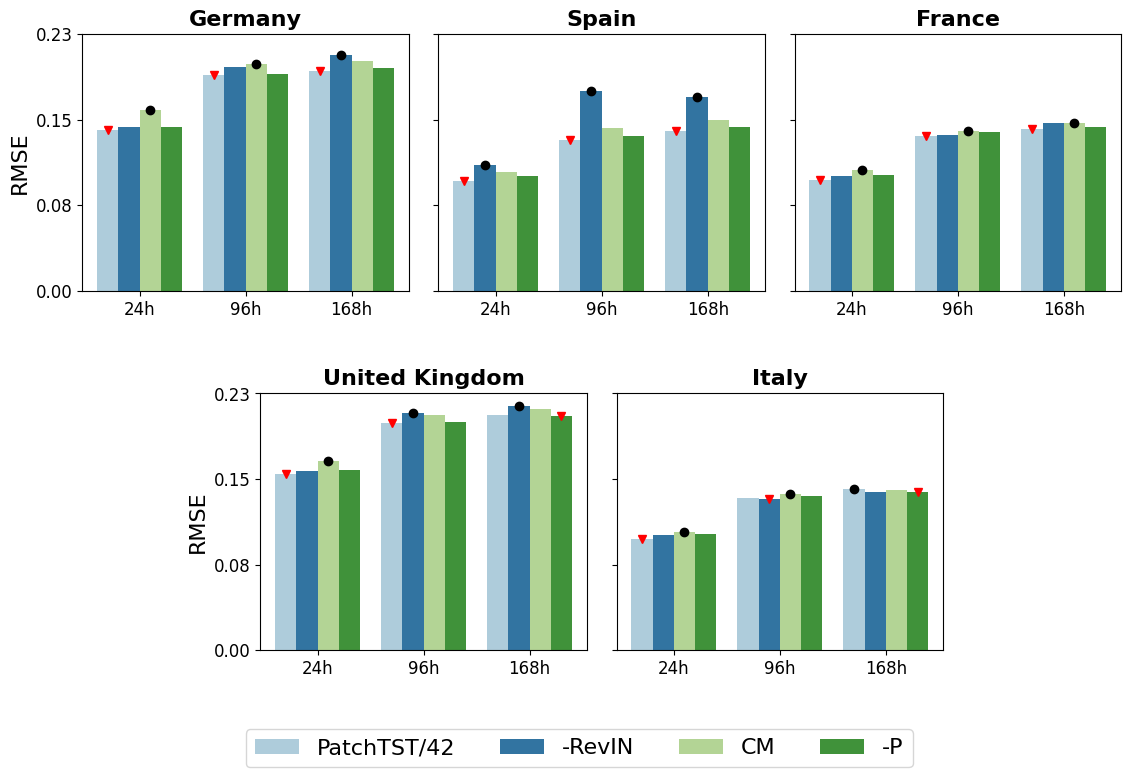

In [9]:
plot_results_models_multiple_countries(all_df, 
                                       function="bars", 
                                       eval_metric='RMSE',
                                       palette="Paired",
                                       plot_max_markers=True,
                                       plot_min_markers=True,
                                       decimal_places=2)

In [26]:
styled_df.to_html(os.path.join(path, 'ablation_10_power_2.html'), index=True)

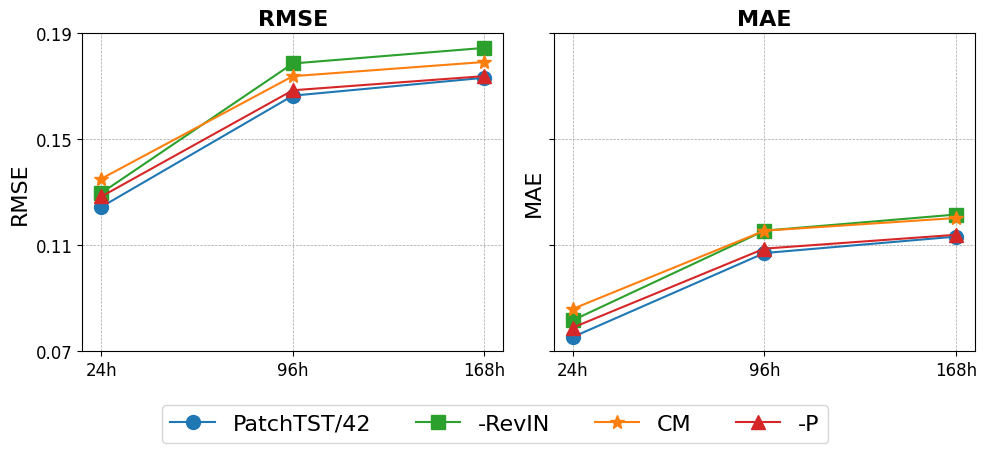

In [27]:
# Averaged by country
# Not clearly visible
to_group = 'Pred_len'
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_comparison_for_metrics(grouped_means, plot_type="lines")

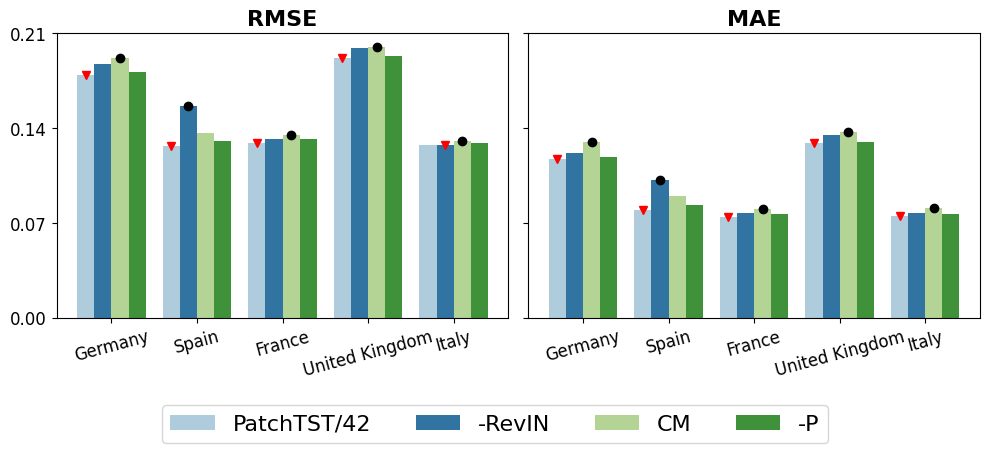

In [7]:
# Averaged by country
to_group = 'Country'
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_comparison_for_metrics(grouped_means,
                             plot_x_axis=to_group, 
                             plot_max_markers=True,
                             plot_min_markers=True,
                             palette="Paired")

# 5. TimeLLM

In [42]:
timellm_df = read_results_csv('timellm/timellm.csv', 
                              columns_to_extract = ('TimeLLM/512', ['RMSE', 'MAE'])
                              )
timellm_df_336 = read_results_csv('timellm/timellm_336.csv', 
                              columns_to_extract = ('TimeLLM/336', ['RMSE', 'MAE'])
                              )
all_df = pd.concat([timellm_df, timellm_df_336, patchtst_64_df, patchtst_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

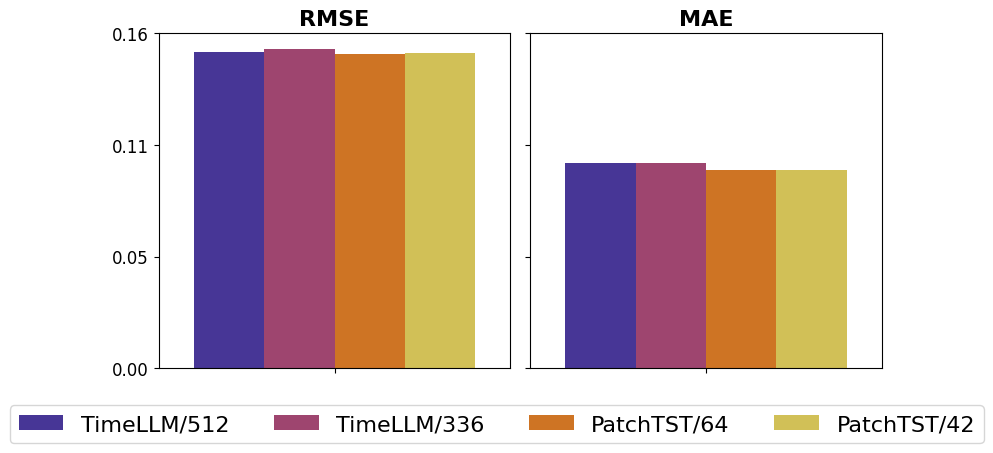

In [43]:
to_group = ['Country', 'Pred_len']
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_barplots(grouped_means, 'Model', col_name='Metrics', palette='CMRmap')

In [ ]:
styled_df.to_html(os.path.join(path, 'timellm_512_10_power_2.html'), index=True)

In [35]:
all_df = pd.concat([timellm_df, patchtst_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [37]:
all_df = pd.concat([timellm_df_336, patchtst_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [38]:
all_df = pd.concat([timellm_df_336, timellm_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

# 6. Decomposition

In [15]:
decomposition_df = read_results_csv('patchtst/patchtst_decomposition.csv', 
                                    columns_to_extract=('Decomposition', ['RMSE', 'MAE'])
                                    )

#all_df = pd.concat([patchtst_df, decomposition_df], axis=1)

# Change country codes to country names
decomposition_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in decomposition_df.index],
    names=level_names
)

# Scale
decomposition_df_scale = decomposition_df * scale
all_df = pd.concat([result_df, decomposition_df_scale], axis=1)

# Highlight the minimum values in bold
styled_df = style_dataframe(all_df, decimal_places=2)
styled_df